In [1]:
from mlgrad.risk import ERisk, ERiskGB
from mlgrad.loss import SquareErrorLoss
from mlgrad.model import LinearFuncModel, SigmaNeuronModel, FFNetworkModel, \
                        FFNetworkFuncModel, SigmaNeuronModelLayer, LinearModel
from mlgrad.func import SoftPlus, Sqrt, Sigmoidal, HingeSqrt, Arctang

from mlgrad import erm_fg, erm_irgd, fg, erm_fg, erisk
from mlgrad.regr import m_regression_irls
from mlgrad.af import averaging_function
from mlgrad.weights import MWeights

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [3]:
noise = 0.3
X, Y = datasets.make_moons(n_samples=200, noise=noise, random_state=0)
print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

(200, 2) (200,)
float64 int64


In [4]:
Y = Y.astype('d')
Y = 2*Y-1
# Y *= 3.

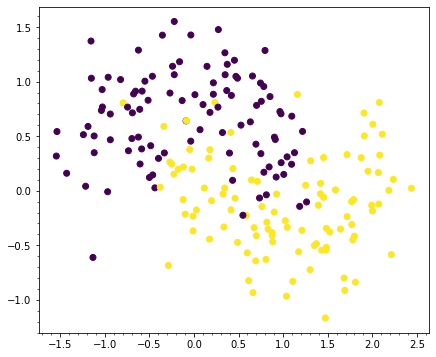

In [5]:
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:, 1], c=Y)
plt.minorticks_on()
plt.show()

In [6]:
def find_alpha(X, E, mod, W=None):
    Yh = np.array([mod(Xk) for Xk in X])
    if W is None:
        alpha = np.sum(E * Yh) / np.sum(Yh * Yh)
    else:
        alpha = np.sum(W * E * Yh) / np.sum(W * Yh * Yh)
    return alpha

In [7]:
def find_alpha_cls(X, E, mod, W=None):
    Yh = np.array([mod(Xk) for Xk in X])
    if W is None:
        alpha = np.sum(E * Yh) / np.sum(Yh * Yh)
    else:
        alpha = np.sum(W * E * Yh) / np.sum(W * Yh * Yh)
    return alpha

In [8]:
def find_param(X, E, mod, loss_func, W=None):
    rs = ERisk(X, E, mod, loss_func)
    if W is not None:
        rs.use_weights(W)
    alg_fg = erm_fg(rs, h=0.001, tol=1.0e-9)

In [9]:
def find_param_alpha_agg(X, Y, lfm, mod, loss_func, agg, n_iter=50, tol=1.0e-6):
    alpha = alpha_min = 1

    W = np.zeros(len(X), 'd')
    L = np.array([loss_func(lfm(Xk), Yk) for Xk, Yk in zip(X, Y)])
    agg.fit(L)
    # lval = lval_min = agg.u
    agg.gradient(L, W)

    param_min = mod.param.copy()

    L = np.array([loss_func(lfm(Xk) + alpha*mod(Xk), Yk) for Xk, Yk in zip(X, Y)])
    agg.fit(L)
    lval = lval_min = agg.u
    # agg.gradient(L, W)
    
    for j in range(n_iter):        
        lval_prev = lval

        E = np.array([(Yk - lfm(Xk))/alpha for Xk, Yk in zip(X,Y)])
        find_param(X, E, mod, loss_func, W)
        
        E = np.array([Yk - lfm(Xk) for Xk, Yk in zip(X,Y)])
        alpha = find_alpha(X, E, mod, W)

        if lval < lval_min:
            param_min = mod.param.copy()
            alpha_min = alpha
            lval_min = lval

        L = np.array([loss_func(lfm(Xk) + alpha*mod(Xk), Yk) for Xk, Yk in zip(X, Y)])
        agg.fit(L)
        lval = agg.u
        # agg.gradient(L, W)
        
        if lval < lval_min:
            param_min = mod.param.copy()
            alpha_min = alpha
            lval_min = lval
            
        if j < 2:
            continue
        
        if abs(lval - lval_prev) / (1 + abs(lval_min)) < tol:
            break
            
    mod.param[:] = param_min
    alpha = alpha_min
    return alpha

In [10]:
def find_param_alpha(X, Y, lfm, mod, loss_func, n_iter=50, tol=1.0e-6):
    lval = lval_min = 10000000.
    alpha_min = alpha = 1

    for j in range(n_iter):
        lval_prev = lval

        E = np.array([(Yk - lfm(Xk))/alpha for Xk, Yk in zip(X,Y)])
        find_param(X, E, mod, loss_func)
        
        E = np.array([Yk - lfm(Xk) for Xk, Yk in zip(X,Y)])
        alpha = find_alpha(X, E, mod)

        lval = np.mean([loss_func(lfm(Xk) + alpha*mod(Xk), Yk) for Xk, Yk in zip(X, Y)])

        if lval < lval_min:
            param_min = mod.param.copy()
            alpha_min = alpha
            lval_min = lval

        if j < 2:
            continue
        
        if abs(lval - lval_prev) / (1 + abs(lval_min)) < tol:
            break

    mod.param[:] = param_min
    alpha = alpha_min
    return alpha        

In [11]:
def gb_fit_agg(X, Y, alpha=0.75, n_iter=30):
    N = len(X)
    lfm = LinearFuncModel()
    agg = averaging_function('WM', alpha=alpha)
    loss_func = SquareErrorLoss()
    lvals = []
    a = 1
    for k in range(n_iter):
        # body = FFNetworkModel()
        # layer = SigmaNeuronModelLayer(Sigmoidal(1.0), X.shape[1], 3)
        # body.add(layer)
        # head = LinearModel(3)
        # mod = FFNetworkFuncModel(head, body)
        # mod.allocate()
        mod = SigmaNeuronModel(Sigmoidal(1.0), X.shape[1])
        mod.init_param()

        a = find_param_alpha_agg(X, Y, lfm, mod, loss_func, agg)
        # print(k, lfm.weights)
        lfm.add(mod, a)

        L = np.array([loss_func(lfm(Xk), Yk) for Xk, Yk in zip(X,Y)])
        agg.fit(L)
        lvals.append(agg.u)
    return lfm, lvals

In [12]:
def gb_fit(X, Y, n_iter=100):
    lfm = LinearFuncModel()
    loss_func = SquareErrorLoss()
    lvals = []
    for k in range(n_iter):
        # body = FFNetworkModel()
        # layer = SigmaNeuronModelLayer(Sigmoidal(1.0), X.shape[1], 3)
        # body.add(layer)
        # head = LinearModel(3)
        # mod = FFNetworkFuncModel(head, body)
        # mod.allocate()
        mod = SigmaNeuronModel(Sigmoidal(1.0), X.shape[1])
        mod.init_param()

        a = find_param_alpha(X, Y, lfm, mod, loss_func)
        lfm.add(mod, a)

        lvals.append(np.mean([loss_func(lfm(Xk), Yk) for Xk, Yk in zip(X,Y)]))
    return lfm, lvals

In [13]:
# I_o = [i for i in range(len(X)) if abs(lfm(X[i])) > 1]
# Y_o = np.array([y for y in Y])
# for i in I_o[-30:]:
#     Y_o[i] = -Y[i]

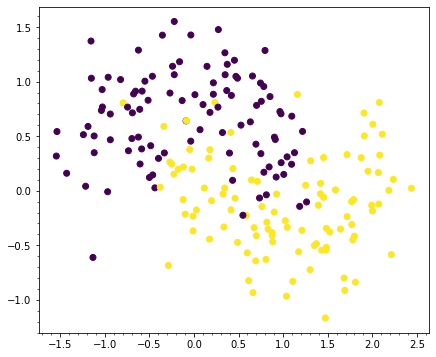

In [14]:
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:, 1], c=Y)
plt.minorticks_on()
plt.show()

In [15]:
lfm, lvals = gb_fit(X, Y, n_iter=50)
# print(np.asarray(lfm.weights))

In [16]:
alpha=0.98
lfm_agg, lvals_agg = gb_fit_agg(X, Y, alpha=alpha, n_iter=50)
# print(np.asarray(lfm_agg.weights))

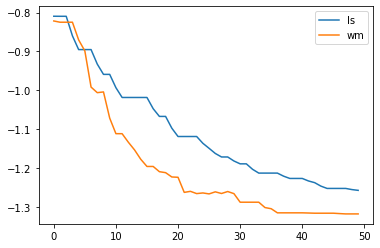

In [17]:
plt.plot(np.log(lvals), label='ls')
plt.plot(np.log(lvals_agg), label='wm')
plt.legend()
plt.show()

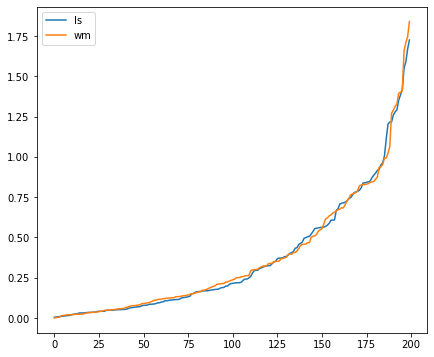

In [18]:
plt.figure(figsize=(7,6))
plt.plot(sorted([abs(lfm(X[k])-Y[k]) for k in range(len(X))]), label='ls')
plt.plot(sorted([abs(lfm_agg(X[k])-Y[k]) for k in range(len(X))]), label='wm')
plt.legend()
plt.show()

In [19]:
Y_ls = np.sign([lfm(Xk) for Xk in X])
Y_agg = np.sign([lfm_agg(Xk) for Xk in X])
acc_ls = 100*round(metrics.accuracy_score(Y, Y_ls), 3)
acc_wm = 100*round(metrics.accuracy_score(Y, Y_agg), 3)

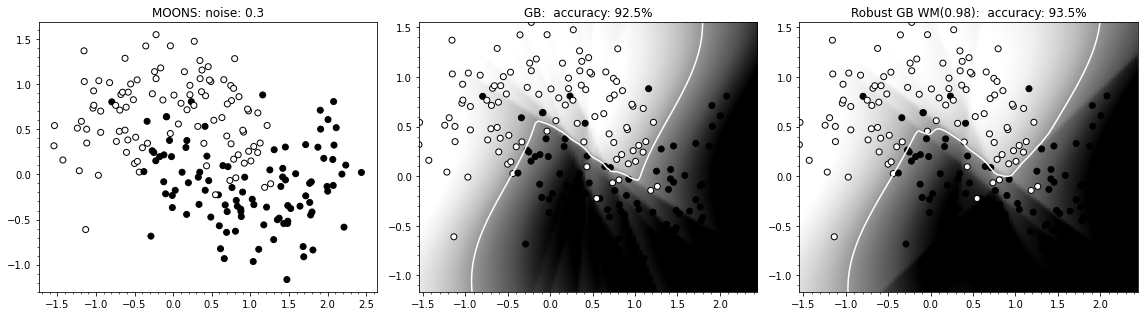

In [20]:
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xrange = np.linspace(x_min, x_max, 100)
yrange = np.linspace(y_min, y_max, 100)
XX, YY = np.meshgrid(xrange, yrange)
X2 = np.c_[XX.ravel(), YY.ravel()]
Z2_ls = np.array([lfm(Xk) for Xk in X2])
Z2_agg = np.array([lfm_agg(Xk) for Xk in X2])
np.putmask(Z2_ls, Z2_ls > 1, 1) 
np.putmask(Z2_ls, Z2_ls < -1, -1) 
np.putmask(Z2_agg, Z2_agg > 1, 1) 
np.putmask(Z2_agg, Z2_agg < -1, -1) 
ZZ_ls = Z2_ls.reshape(XX.shape)
ZZ_agg = Z2_agg.reshape(XX.shape)

levels = [ 0.,]
plt.figure(figsize=(16,4.5))
plt.subplot(1,3,1)
plt.title("MOONS: noise: %.1f" % noise)
plt.scatter(X[:,0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Greys)
plt.minorticks_on()
plt.subplot(1,3,2)
plt.title("GB:  accuracy: %.1f%%" % (acc_ls))
plt.scatter(X[:,0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Greys)
cb = plt.imshow(ZZ_ls, aspect='auto', origin='lower', extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
cs = plt.contour(ZZ_ls, levels=levels, extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
# plt.clabel(cs, levels=levels)
# plt.colorbar(cb)
plt.minorticks_on()
plt.subplot(1,3,3)
plt.title("Robust GB WM(%.2f):  accuracy: %.1f%%" % (alpha, acc_wm))
plt.scatter(X[:,0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Greys)
cb = plt.imshow(ZZ_agg, aspect='auto', origin='lower', extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
cs = plt.contour(ZZ_agg, levels=levels, extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
# plt.clabel(cs, levels=levels)
# plt.colorbar(cb)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('rob_gb_%.0f.eps' % round(noise*100))
plt.show()